In [ ]:
import pandas as pd
import os
import shutil

# Path to the directory containing the images and labels CSV file
data_dir = '/kaggle/input/affectnet-training-data'

# Read the labels CSV file (adjust the filename/path as needed)
csv_file = os.path.join(data_dir, 'labels.csv')
labels_df = pd.read_csv(csv_file)

# Emotions to use (ensure all lowercase for consistency)
selected_emotions = ['anger', 'sad', 'happy', 'fear']

# Move or copy the selected images to a new directory preserving folder structure
selected_dir = 'selected_images_f'
os.makedirs(selected_dir, exist_ok=True)

# Function to extract emotion label from file path
def extract_label_from_path(file_path):
    # Example file path structure: 'anger/image0000006.jpg'
    parts = file_path.split('/')  # Split by directory separator '/'
    if len(parts) >= 2:
        emotion_label = parts[-2]  # Second-to-last part is the emotion label directory
        return emotion_label.lower()  # Return lowercase label
    else:
        return None  # Return None if label extraction fails

# Filter and process each image
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg')or file.endswith('.png') :  # Process only JPG images (adjust file extension if needed)
            src_path = os.path.join(root, file)
            emotion_label = extract_label_from_path(os.path.relpath(src_path, data_dir))
            
            if emotion_label and emotion_label in selected_emotions:
                # Determine destination subdirectory within selected_dir
                dest_subdir = os.path.join(selected_dir, emotion_label)
                os.makedirs(dest_subdir, exist_ok=True)
                
                # Construct destination path
                dst_path = os.path.join(dest_subdir, file)
                
                # Copy file from source to destination
                shutil.copy(src_path, dst_path)
            else:
                print(f"Ignoring: {src_path} (Invalid or non-selected emotion)")
                
print("Selected images for specified emotions have been copied to the 'selected_images' directory with preserved folder structure.")


In [ ]:
import os
from os.path import join
import pandas as pd
import cv2
import matplotlib.pyplot as plt  
import random
import numpy as np
from keras.utils import to_categorical


2024-05-16 12:47:41.421185: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 12:47:41.421336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 12:47:41.551432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
INPUT_PATH = "/kaggle/working/selected_images_f"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (128, 128)

In [10]:
import os

# Define the path to the directory containing emotion folders
INPUT_PATH = "/kaggle/working/selected_images_f"

# Get a list of subdirectories (emotions) in the INPUT_PATH
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]

# Dictionary to store counts of images in each emotion category
emotion_image_counts = {}

# Iterate through each emotion folder
for emotion in EMOTIONS:
    # Construct the full path to the emotion folder
    emotion_path = os.path.join(INPUT_PATH, emotion)
    
    # Count the number of files (images) in the emotion folder
    num_images = len([f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))])
    
    # Store the count in the dictionary
    emotion_image_counts[emotion] = num_images

# Print the counts of images in each emotion category
for emotion, count in emotion_image_counts.items():
    print(f"Emotion: {emotion}, Number of Images: {count}")


Emotion: anger, Number of Images: 3218
Emotion: sad, Number of Images: 3091
Emotion: fear, Number of Images: 3176
Emotion: happy, Number of Images: 5044


In [11]:
EMOTIONS

['anger', 'sad', 'fear', 'happy']

In [12]:
def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, image_size)
            img = img.astype('float32') / 255.0 
            yield img, index

In [13]:
def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

In [14]:
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)

In [15]:
input_shape = X[0].shape

In [16]:
input_shape

(128, 128, 3)

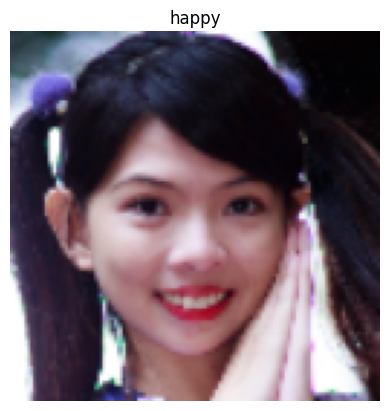

In [17]:
# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.axis('off')  # remove the grid
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model_3 = Sequential()

model_3.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(4, activation='softmax'))

model_3.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,692,164 (6.46 MB)

 Trainable params: 1,690,052 (6.45 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the filepath with .weights.h5 extension
checkpoint_filepath = 'best_model.weights.h5'

# Configure callbacks with corrected filepath
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=2, verbose=1),
    ModelCheckpoint(
        checkpoint_filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# Example usage in model.fit()
history = model_3.fit(
    X_train, 
    y_train, 
    batch_size=64,
    epochs=25,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25
  2/182 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.2383 - loss: 5.2146   

I0000 00:00:1715862145.270254     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715862145.297579     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5707 - loss: 3.3631

W0000 00:00:1715862172.542863     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715862174.856798     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 58s 182ms/step - accuracy: 0.5709 - loss: 3.3593 - val_accuracy: 0.6497 - val_loss: 1.6157 - learning_rate: 0.0010
Epoch 2/25


W0000 00:00:1715862178.234137     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.6908 - loss: 1.3459 - val_accuracy: 0.6872 - val_loss: 0.9173 - learning_rate: 0.0010
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7238 - loss: 0.8514 - val_accuracy: 0.7316 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7433 - loss: 0.7604 - val_accuracy: 0.6022 - val_loss: 1.2905 - learning_rate: 0.0010
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7571 - loss: 0.7330 - val_accuracy: 0.7536 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7706 - loss: 0.7044 - val_accuracy: 0.7130 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 7/25
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7871 - loss: 0.6899
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.7870 - loss: 0.6901 

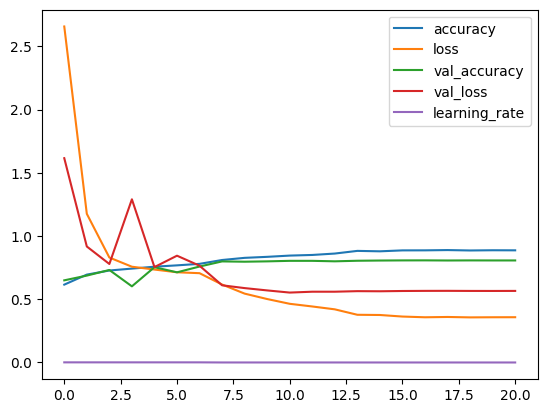

In [21]:
pd.DataFrame(history.history).plot();

In [22]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_3.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

19/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

W0000 00:00:1715862513.129754     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       641
           1       0.68      0.64      0.66       618
           2       0.77      0.72      0.74       644
           3       1.00      0.99      0.99      1003

    accuracy                           0.81      2906
   macro avg       0.78      0.78      0.78      2906
weighted avg       0.81      0.81      0.81      2906



W0000 00:00:1715862514.852452     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


model = Sequential()

model.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,692,164 (6.46 MB)

 Trainable params: 1,690,052 (6.45 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the filepath with .weights.h5 extension
checkpoint_filepath = 'best_model.weights.h5'

# Configure callbacks with corrected filepath
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=2, verbose=1),
    ModelCheckpoint(
        checkpoint_filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# Example usage in model.fit()
history = model.fit(
    X_train, 
    y_train, 
    batch_size=64,
    epochs=25,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25
  2/182 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.2422 - loss: 5.2752 

W0000 00:00:1715862547.312117     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5685 - loss: 3.3728

W0000 00:00:1715862570.044935     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715862571.894462     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.5688 - loss: 3.3691 - val_accuracy: 0.6820 - val_loss: 1.6105 - learning_rate: 0.0010
Epoch 2/25


W0000 00:00:1715862573.683746     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.6856 - loss: 1.3736 - val_accuracy: 0.6834 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.7334 - loss: 0.8413 - val_accuracy: 0.7330 - val_loss: 0.7791 - learning_rate: 0.0010
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7475 - loss: 0.7640 - val_accuracy: 0.6132 - val_loss: 1.3631 - learning_rate: 0.0010
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7626 - loss: 0.7378 - val_accuracy: 0.7643 - val_loss: 0.7427 - learning_rate: 0.0010
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7750 - loss: 0.7186 - val_accuracy: 0.7099 - val_loss: 0.8419 - learning_rate: 0.0010
Epoch 7/25
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7855 - loss: 0.6831
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7855 - loss: 0.6833 

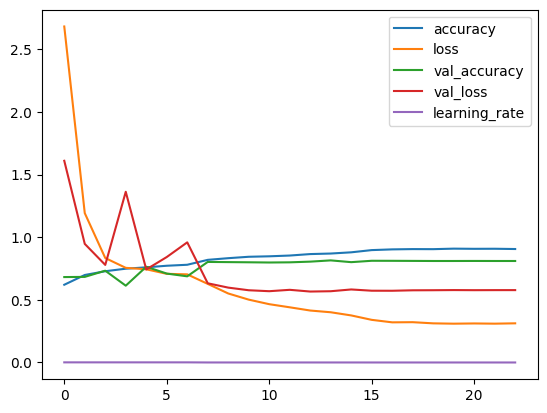

In [25]:
pd.DataFrame(history.history).plot();

In [26]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

13/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

W0000 00:00:1715862906.862642     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       641
           1       0.69      0.65      0.67       618
           2       0.76      0.74      0.75       644
           3       1.00      0.99      0.99      1003

    accuracy                           0.81      2906
   macro avg       0.78      0.78      0.78      2906
weighted avg       0.81      0.81      0.81      2906



W0000 00:00:1715862908.638401     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
 EMOTIONS

['anger', 'sad', 'fear', 'happy']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


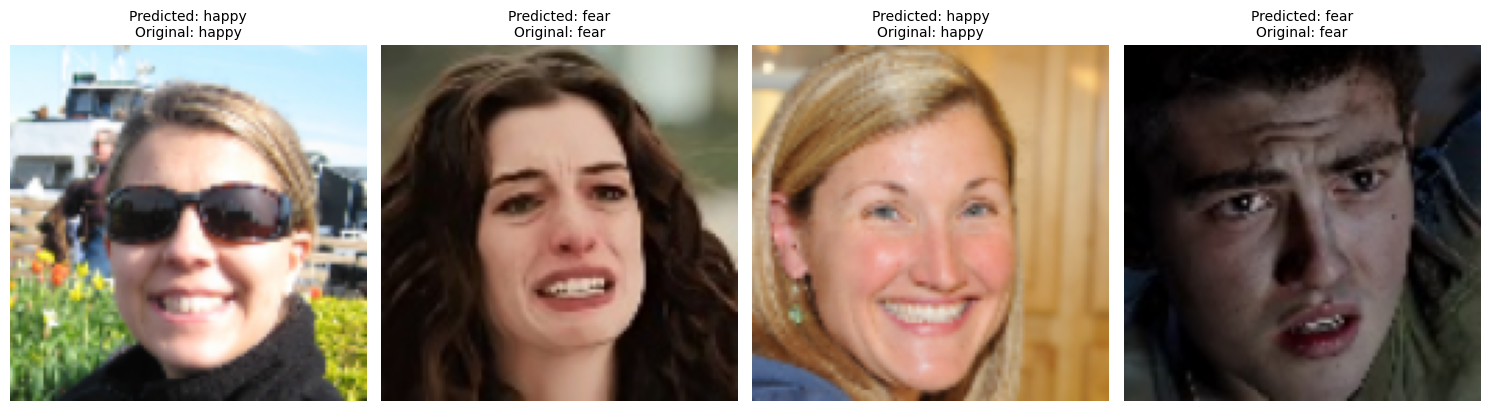

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define your class labels (assuming 8 classes for this example)
class_labels = ['anger', 'sad', 'fear', 'happy']

# Function to predict and plot random test images with predicted and original labels
def predict_and_plot_test_images(model, x_test, y_test, class_labels, num_images=4):
    # Get random indices from the test data
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)

    # Create subplots grid
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    # Iterate over each subplot
    for i, idx in enumerate(random_indices):
        # Get the test image and true label
        test_image = x_test[idx]
        true_label = class_labels[np.argmax(y_test[idx])]

        # Expand dimensions to match model input shape (if needed)
        test_image = np.expand_dims(test_image, axis=0)

        # Predict using the model
        prediction = model.predict(test_image)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display the image and predicted/original labels
        axs[i].imshow(test_image.squeeze())  # Assuming test_image has shape (1, height, width, channels)
        axs[i].set_title(f'Predicted: {predicted_label}\nOriginal: {true_label}', fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Assuming you have x_test and y_test arrays
# Replace 'model_3' with your trained model and adjust 'num_images' as needed
predict_and_plot_test_images(model, X_test, y_test, class_labels, num_images=4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


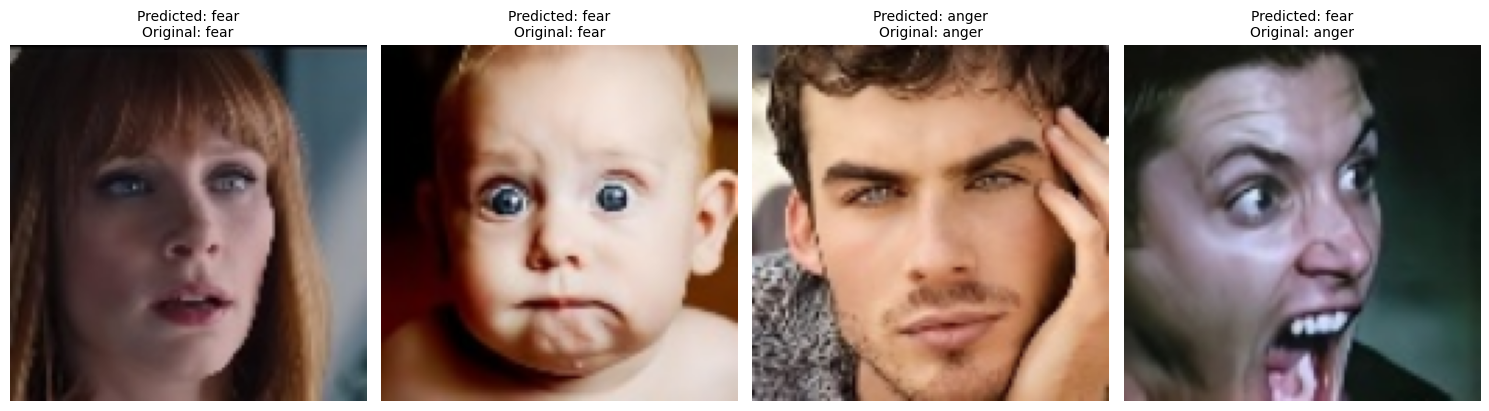

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define your class labels (assuming 8 classes for this example)

# Function to predict and plot random test images with predicted and original labels
def predict_and_plot_test_images(model, x_test, y_test, class_labels, num_images=4):
    # Get random indices from the test data
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)

    # Create subplots grid
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    # Iterate over each subplot
    for i, idx in enumerate(random_indices):
        # Get the test image and true label
        test_image = x_test[idx]
        true_label = class_labels[np.argmax(y_test[idx])]

        # Expand dimensions to match model input shape (if needed)
        test_image = np.expand_dims(test_image, axis=0)

        # Predict using the model
        prediction = model.predict(test_image)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display the image and predicted/original labels
        axs[i].imshow(test_image.squeeze())  # Assuming test_image has shape (1, height, width, channels)
        axs[i].set_title(f'Predicted: {predicted_label}\nOriginal: {true_label}', fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Assuming you have x_test and y_test arrays
# Replace 'model_3' with your trained model and adjust 'num_images' as needed
predict_and_plot_test_images(model_3, X_test, y_test, class_labels, num_images=4)


In [37]:
import cv2
import os
import numpy as np



def preprocess_image_for_prediction(image_path, target_size=(96, 96)):
    # Load the image using OpenCV (assuming image_path is the path to your image)
    img = cv2.imread(image_path)
    
    # Convert color from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the target size
    img = cv2.resize(img, target_size)
    
    # Convert the pixel values to float32 and normalize to range [0, 1]
    img = img.astype('float32') / 255.0
    
    # Add batch dimension (model expects input shape of (1, 96, 96, 3))
    img = np.expand_dims(img, axis=0)
    
    return img

# Example usage:
image_path = '/kaggle/input/images/happy_pk.jpg'
preprocessed_image = preprocess_image_for_prediction(image_path, target_size=(128, 128))

# Now you can use preprocessed_image as input to your model for prediction
# Assuming 'model' is your trained model loaded previously
prediction = model_3.predict(preprocessed_image)

# Assuming class_labels is defined as ['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']
predicted_label = class_labels[np.argmax(prediction)]

print(f'Predicted Label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Label: happy


In [40]:
model_3.save('model_f.h5')